In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
X_df = pd.read_csv("X_train")
y_df = pd.read_csv("Y_train")
X_df.head()

,id,age,Private,Self-employed-incorporated,State government,Self-employed-not incorporated,Not in universe,Without pay,Federal government,Never worked,...,1.2,Not in universe.12,Yes.3,No.3,2.3,0.3,1.3,weeks worked in year,94,95
0,0,33,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
1,1,63,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
2,2,71,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,3,43,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
4,4,57,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1


In [3]:
raw_X = X_df.iloc[:, 1:].to_numpy().astype(np.float)
y = y_df.iloc[:, 1:].to_numpy().astype(np.float).flatten()

## Normalization

In [4]:
mean = np.mean(raw_X, axis=0)
std = np.std(raw_X, axis=0)
trivial_columns = std < 1e-8
X = (raw_X - mean)/std
X = X[:, ~trivial_columns]

## Shuffle and Split

- Randomly shuffle X
- Split X into train_X and val_X

In [5]:
perm = np.random.permutation(X.shape[0])
X = X[perm, :]
y = y[perm]
train_size = math.floor(0.8 * X.shape[0])
train_X = X[:train_size, :]
val_X = X[train_size:, :]
train_y = y[:train_size]
val_y = y[train_size:]

## Train

In [24]:
train_loss = []
val_loss = []
def sigmoid(x):
    return np.clip(1 / (1 + np.exp(-x)), 1e-8, 1 - 1e-8) # Set maximum and minimum value to avoid overflow
def loss_func(pred, y):
    return (-np.inner(y, np.log(pred)) - np.inner(1 - y, np.log(1 - pred))) / y.shape[0]
class LogisticRegressor:
    def predict(self, X):
        X = np.hstack((np.ones([X.shape[0], 1]), X))
        return sigmoid(np.squeeze(np.dot(X, self.theta)))
    def train(self, X, y, lr = 0.5, iters = 1000):
        X = np.hstack((np.ones([X.shape[0], 1]), X))
        self.theta = np.random.normal(0, 1, [X.shape[1], 1])
        for i in range(iters):
            pred = sigmoid(np.squeeze(np.dot(X, self.theta)))
            grad = np.dot(X.T, np.expand_dims(pred - y, 1)) / X.shape[0]
            self.theta -= lr * grad
            train_loss.append(loss_func(pred, y))
            val_loss.append(loss_func(self.predict(val_X), val_y))

In [31]:
import time
start_time = time.time()
model = LogisticRegressor()
model.train(train_X, train_y)
time.time() - start_time

## Plot the training curve

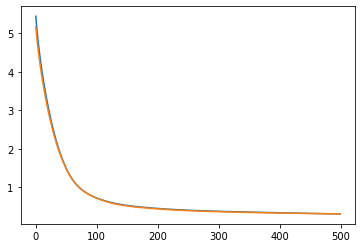

Last val_loss: 0.3118858843749521


In [8]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(len(val_loss)), val_loss)
plt.show()
print("Last val_loss: {}".format(val_loss[-1]))

## Predict for the test data

In [25]:
final_model = LogisticRegressor()
final_model.train(X, y)

In [26]:
test_X_df = pd.read_csv("X_test")
test_X_df.head()

,id,age,Private,Self-employed-incorporated,State government,Self-employed-not incorporated,Not in universe,Without pay,Federal government,Never worked,...,1.2,Not in universe.12,Yes.3,No.3,2.3,0.3,1.3,weeks worked in year,94,95
0,0,37,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
1,1,48,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
2,2,68,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
3,3,74,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,52,0,1
4,4,18,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1


In [27]:
test_X = test_X_df.iloc[:, 1:].to_numpy().astype(np.float)
test_X = (test_X - mean) / std
test_X = test_X[:, ~trivial_columns]
test_pred = (final_model.predict(test_X) > 0.5).astype(np.int)

In [29]:
answer_list = [(i, test_pred[i]) for i in range(test_pred.shape[0])]
answer_df = pd.DataFrame(answer_list)
answer_df.to_csv("submit.csv", header=["id", "label"], index=False)